Sentiment Analysis Of Hotel Reviews of Yelp.com

In [60]:
import pandas as pd   
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.preprocessing import sequence
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.layers import Flatten
from keras.models import Model
from keras.optimizers import RMSprop,Adam
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Data Loading

In [29]:
df1=pd.read_csv("train.csv")
df2=pd.read_csv("test.csv")
df1.head()



df1=df1.drop(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateSeen',
       'reviews.sourceURLs', 'reviews.title','reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'websites'], axis=1)
df2=df2.drop(['Hotel Name','hotel Url'], axis=1)

df = pd.concat([df1, df2],ignore_index=True)
df

,reviews.rating,reviews.text
0,5.0,Our experience at Rancho Valencia was absolute...
1,5.0,Amazing place. Everyone was extremely warm and...
2,5.0,We booked a 3 night stay at Rancho Valencia to...
3,2.0,Currently in bed writing this for the past hr ...
4,5.0,I live in Md and the Aloft is my Home away fro...
...,...,...
15190,5.0,Love the atmosphere and the food is to die for...
15191,5.0,This is easily the best soul food out there (p...
15192,5.0,I'm so amazed about the service here Elliott a...
15193,5.0,The food was outstanding. As a real southern g...


Data Preprocessing

In [30]:
df.isnull().values.any()

df.shape


(15195, 2)

In [31]:
a=[]
for i in df["reviews.rating"]:
    if i <= 3:
        a.append(0)
    else:
        a.append(1)
df["label"]=a
df["reviews.text"][5]

'I stayed here with my family for my daughters wedding. It had a very accommodating staff, Olivia was excellent. The rooms were very well maintained. Would highly recommend this hotel, especially if your wedding venue is Celebrations at the Bay!'

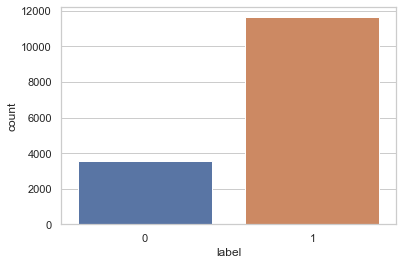

In [32]:
import seaborn as sns

sns.countplot(x='label', data=df)

In [33]:
import re
stop = set(stopwords.words("english"))
def preprocessor(text):
    text = re.sub("<[^>]*>","", str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text
ps = PorterStemmer()

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", str(text))


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", str(text))

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", str(text))

def remove_punct(text):
    text= str(text)
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    text=str(text)
    text = [ps.stem(word) for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

df["reviews.text"]=df['reviews.text'].apply(preprocessor)
df["reviews.text"]=df['reviews.text'].apply(remove_punct)
df["reviews.text"]=df['reviews.text'].apply(remove_stopwords)
df["reviews.text"]=df['reviews.text'].apply(remove_emoji)
df["reviews.text"]=df['reviews.text'].apply(remove_html)
df["reviews.text"]=df['reviews.text'].apply(remove_URL)

In [34]:
df["reviews.text"]


0        experi rancho valencia absolut perfect begin e...
1        amaz place everyon extrem warm welcom stay top...
2        book 3 night stay rancho valencia play tenni s...
3        current bed write past hr 1 2 dog bark squeal ...
4        live md aloft home away home stay 1 night 7 7 ...
                               ...                        
15190           love atmospher food die staff member polit
15191    easili best soul food period servic fantast we...
15192    amaz servic elliott nelson best nelson attent ...
15193    food outstand real southern girl definit recom...
15194    love ladi brunch make reserv restaur accommod ...
Name: reviews.text, Length: 15195, dtype: object

In [35]:
df['Num_words_text'] = df['reviews.text'].apply(lambda x:len(str(x).split())) 
df['Num_words_text'].describe()

count    15195.000000
mean        41.563277
std         38.803973
min          0.000000
25%         21.000000
50%         30.000000
75%         48.000000
max        573.000000
Name: Num_words_text, dtype: float64

No of Short reviews
10762
No of Long reviews
1151


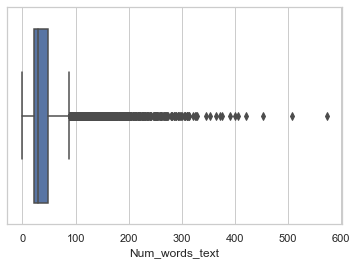

In [36]:
sns.set(style="whitegrid")
sns.boxplot(x=df['Num_words_text'])

mask = (df['Num_words_text'] < 100) & (df['Num_words_text'] >=20)
df_short_reviews = df[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = df['Num_words_text'] >= 100
df_long_reviews = df[mask]
print('No of Long reviews')
print(len(df_long_reviews))

In [37]:
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(df["reviews.text"].values)
np.set_printoptions(precision=3)


tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)


Initialising and Splitting Dataset

In [38]:
X=tfidf.fit_transform(X).toarray()

In [39]:
y=df["label"].values

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

LogisticRegression

In [41]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=100,random_state=42)
LR.fit(X_train, y_train)

LogisticRegression(random_state=42)

Support Vector Machines

In [42]:
from sklearn import svm
SVM = svm.LinearSVC(random_state=42)
SVM.fit(X_train, y_train)

LinearSVC(random_state=42)

Naive Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

Classification metrics

[[ 361  342]
 [  70 2266]]
              precision    recall  f1-score   support

           0       0.84      0.51      0.64       703
           1       0.87      0.97      0.92      2336

    accuracy                           0.86      3039
   macro avg       0.85      0.74      0.78      3039
weighted avg       0.86      0.86      0.85      3039

0.8644290885159592


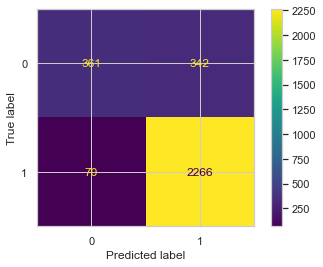

In [44]:
pred=LR.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(accuracy_score(y_test, pred))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR, X_test, y_test) 

[[ 421  282]
 [ 132 2204]]
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       703
           1       0.89      0.94      0.91      2336

    accuracy                           0.86      3039
   macro avg       0.82      0.77      0.79      3039
weighted avg       0.86      0.86      0.86      3039

0.8637709772951628


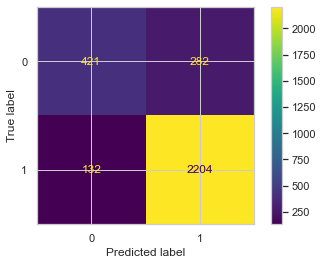

In [45]:

pred=SVM.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(accuracy_score(y_test, pred))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVM, X_test, y_test) 

[[  76  627]
 [   8 2328]]
              precision    recall  f1-score   support

           0       0.90      0.11      0.19       703
           1       0.79      1.00      0.88      2336

    accuracy                           0.79      3039
   macro avg       0.85      0.55      0.54      3039
weighted avg       0.81      0.79      0.72      3039

0.7910496873971701


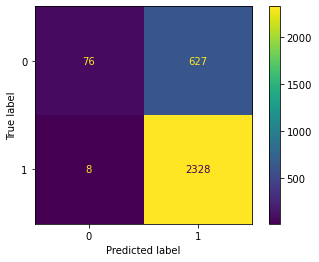

In [18]:
pred=nb.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(accuracy_score(y_test, pred))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(nb, X_test, y_test) 

 LSTM Implementation

In [46]:
X=np.array(df["reviews.text"])
Y=np.array(df["label"])

In [47]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [48]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=42)

In [49]:
max_words = 5000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [50]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [25]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           250000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [28]:
history=model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',mode='min',min_delta=0.0001)])

Epoch 1/10
76/76 [==============================] - 18s 235ms/step - loss: 0.4686 - accuracy: 0.7918 - val_loss: 0.3396 - val_accuracy: 0.8512
Epoch 2/10
76/76 [==============================] - 15s 203ms/step - loss: 0.3009 - accuracy: 0.8795 - val_loss: 0.3317 - val_accuracy: 0.8569
Epoch 3/10
76/76 [==============================] - 16s 205ms/step - loss: 0.2516 - accuracy: 0.9001 - val_loss: 0.3463 - val_accuracy: 0.8540


In [ ]:
#model.fit(sequences_matrix,Y_train,batch_size=128,epochs=200/100,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',mode='min',min_delta=0.0001)])======== 0.86
#model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2)#,callbacks=[EarlyStopping(monitor='val_loss',mode='min',min_delta=0.0001)])======== 0.86

In [29]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [30]:
accr = model.evaluate(test_sequences_matrix,Y_test)

95/95 [==============================] - 3s 32ms/step - loss: 0.3428 - accuracy: 0.8565


In [31]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.343
  Accuracy: 0.857


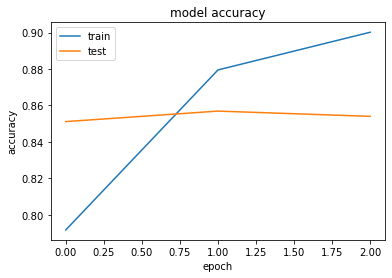

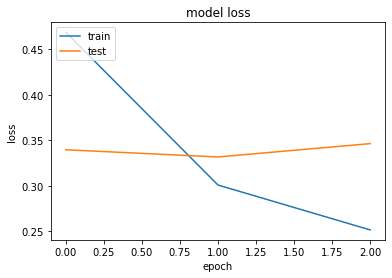

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [76]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [77]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1555400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,672,777
Trainable params: 1,672,777
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/5
76/76 [==============================] - 11s 141ms/step - loss: 0.5542 - acc: 0.7590 - val_loss: 0.5370 - val_acc: 0.7714
Epoch 2/5
76/76 [==============================] - 13s 166ms/step - loss: 0.5404 - acc: 0.7651 - val_loss: 0.5326 - val_acc: 0.7722
Epoch 3/5
76/76 [==============================] - 14s 183ms/step - loss: 0.5449 - acc: 0.7761 - val_loss: 0.5321 - val_acc: 0.7710
Epoch 4/5
76/76 [==============================] - 14s 182ms/step - loss: 0.5290 - acc: 0.7775 - val_loss: 0.5315 - val_acc: 0.7714
Epoch 5/5
95/95 [==============================] - 2s 22ms/step - loss: 0.5365 - acc: 0.7680


In [79]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5364730358123779
Test Accuracy: 0.7680158019065857


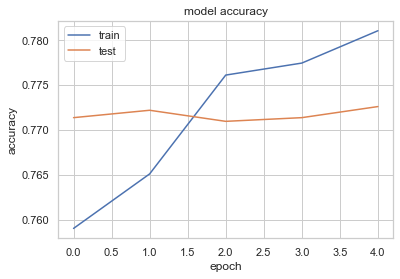

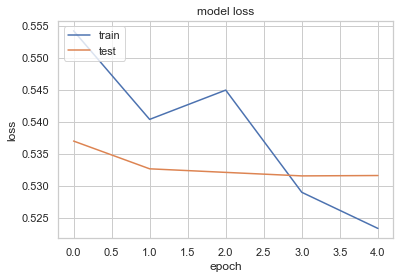

In [80]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()